<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-II-Computer-Vision/03_better_convolutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Better Convolutions

This time, let's use a different dataset: Rock Paper Scissors.

The dataset contains 2,892 images of diverse hands in the typical rock, paper, and
scissors poses against a white background. This is a synthetic dataset as well since
the images were generated using CGI techniques. Each image is 300x300 pixels in
size and has four channels (RGBA).

Here are some examples of its images, one for each pose.

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-II-Computer-Vision/images/download.png?raw=1)

##Setup

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
try:
    import google.colab
    import requests
    url = 'https://raw.githubusercontent.com/dvgodoy/PyTorchStepByStep/master/config.py'
    r = requests.get(url, allow_redirects=True)
    open('config.py', 'wb').write(r.content)    
except ModuleNotFoundError:
    pass

from config import *
config_chapter6()
# This is needed to render the plots in this chapter
from plots.chapter6 import *

Finished!


In [3]:
import numpy as np
from PIL import Image
from copy import deepcopy

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision.transforms import Compose, ToTensor, Normalize, ToPILImage, Resize
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, MultiStepLR, CyclicLR, LambdaLR

from stepbystep.v2 import StepByStep

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
import os
# content/gdrive/My Drive/Kaggle is the path where kaggle.json is  present in the Google Drive
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/kaggle-keys"

In [6]:
%%shell

# download dataset from kaggle> URL: https://www.kaggle.com/datasets/sanikamal/rock-paper-scissors-dataset
kaggle datasets download -d sanikamal/rock-paper-scissors-dataset

unzip -qq rock-paper-scissors-dataset.zip
rm -rf rock-paper-scissors-dataset.zip

 96% 436M/452M [00:03<00:00, 180MB/s]
100% 452M/452M [00:03<00:00, 145MB/s]


## Data Preparation

The data preparation step will be a bit more demanding this time since we’ll be
standardizing the images.Besides, we can use the ImageFolder dataset now.

The Rock Paper Scissors dataset is organized like that:

```
rps/paper/paper01-000.png
rps/paper/paper01-001.png

rps/rock/rock01-000.png
rps/rock/rock01-001.png

rps/scissors/scissors01-000.png
rps/scissors/scissors01-001.png
```

The dataset is also perfectly balanced, with each sub-folder containing 840 images
of its particular class.

Let’s create a dataset then:

In [7]:
ROOT_FOLDER = "Rock-Paper-Scissors"
temp_transform = Compose([Resize(28), ToTensor()])
temp_dataset = ImageFolder(root=ROOT_FOLDER, transform=temp_transform)

In [8]:
temp_dataset[0][0].shape, temp_dataset[0][1]

(torch.Size([3, 28, 28]), 0)

###Standardization

To standardize data points, we need to learn their mean and standard deviation
first.

To compute these, we need to load the data.

The good thing is, we have
a (temporary) dataset with the resized images already! We’re only missing a data
loader.

In [9]:
temp_loader = DataLoader(temp_dataset, batch_size=16)

So, let’s build a function that takes a mini-batch (images and labels) and computes
the mean pixel value and standard deviation per channel of each image, adding up
the results for all images.

In [10]:
@staticmethod
def statistics_per_channel(images, labels):
  # NCHW
  n_samples, n_channels, n_height, n_weight = images.size()
  # Flatten HW into a single dimension
  flatten_per_channel = images.reshape(n_samples, n_channels, -1)

  # Computes statistics of each image per channel
  # Average pixel value per channel (n_samples, n_channels)
  means = flatten_per_channel.mean(axis=2)
  # Standard deviation of pixel values per channel (n_samples, n_channels)
  stds = flatten_per_channel.std(axis=2)

  # Adds up statistics of all images in a mini-batch (1, n_channels)
  sum_means = means.sum(axis=0)
  sum_stds = stds.sum(axis=0)

  # Makes a tensor of shape (1, n_channels) with the number of samples in the mini-batch
  n_samples = torch.tensor([n_samples] * n_channels).float()

  # Stack the three tensors on top of one another (3, n_channels)
  return torch.stack([n_samples, sum_means, sum_stds], axis=0)

setattr(StepByStep, 'statistics_per_channel', statistics_per_channel)

In [11]:
first_images, first_labels = next(iter(temp_loader))
StepByStep.statistics_per_channel(first_images, first_labels)

tensor([[16.0000, 16.0000, 16.0000],
        [15.0968, 14.0652, 13.5893],
        [ 0.8948,  2.3599,  3.1430]])

We can leverage the `loader_apply()` method we created in the last chapter to get
the sums for the whole dataset:

In [12]:
results = StepByStep.loader_apply(temp_loader, StepByStep.statistics_per_channel)
results

tensor([[2925.0000, 2925.0000, 2925.0000],
        [2506.6553, 2419.2803, 2387.8225],
        [ 583.3219,  713.7609,  761.2370]])

So, we can compute the average mean value and the
average standard deviation, per channel. 

Better yet, let’s make it a method that
takes a data loader and returns an instance of the `Normalize()` transform,
statistics and all:

In [13]:
@staticmethod
def make_normalizer(loader):
  total_samples, total_means, total_stds = StepByStep.loader_apply(temp_loader, StepByStep.statistics_per_channel)
  norm_mean = total_means / total_samples
  norm_std = total_stds / total_samples
  return Normalize(mean=norm_mean, std=norm_std)

setattr(StepByStep, 'make_normalizer', make_normalizer)

Now, we can use this method to create a transformation that standardizes our
dataset:

In [14]:
normalizer = StepByStep.make_normalizer(temp_loader)
normalizer

Normalize(mean=tensor([0.8570, 0.8271, 0.8163]), std=tensor([0.1994, 0.2440, 0.2603]))

###Real Datasets

It’s time to build our real datasets using the `Normalize()` transform with the
statistics.

In [15]:
composer = Compose([Resize(28), ToTensor(), normalizer])

train_data = ImageFolder(root=f"{ROOT_FOLDER}/train", transform=composer)
val_data = ImageFolder(root=f"{ROOT_FOLDER}/test", transform=composer)

# Builds a loader of each set
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16)

Let’s take a peek at some images from the real training set.

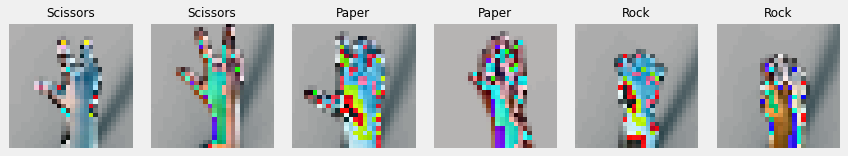

In [16]:
torch.manual_seed(88)

first_images, first_labels = next(iter(train_loader))

fig = figure2(first_images, first_labels)

##Three-Channel Convolutions

Convolving a three-channel filter over a three-channel image still produces a
single value.

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-II-Computer-Vision/images/3channel1.png?raw=1)

Adding up the results for each
channel produces the expected single value.

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-II-Computer-Vision/images/3channel2.png?raw=1)

We can also look at it in code.

In [17]:
regions = np.array([[[[5, 0, 8],
                      [1, 9, 5],
                      [6, 0, 2]],
                     [[0, 5, 4],
                      [8, 1, 9],
                      [4, 8, 1]],
                     [[4, 2, 0],
                      [6, 3, 0],
                      [5, 2, 8]]]])
regions.shape

(1, 3, 3, 3)

In [18]:
three_channel_filter = np.array([[[[0, 3, 0],
                                   [1, 0, 1],
                                   [2, 1, 0]],
                                  [[2, 1, 0],
                                   [0, 3, 1],
                                   [1, -1, 0]],
                                  [[0, 1, 3],
                                   [-1, -2, 0],
                                   [2, 0, 1]]]])
three_channel_filter.shape

(1, 3, 3, 3)

In [19]:
result = F.conv2d(torch.as_tensor(regions), torch.as_tensor(three_channel_filter))
result, result.shape

(tensor([[[[39]]]]), torch.Size([1, 1, 1, 1]))

What if I have two filters?

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-II-Computer-Vision/images/3channel_filters1.png?raw=1)

If you have two filters, and the input image has three channels, each filter has
three channels as well, and the output has two channels.

>The convolution produces as many channels as there are filters.


##Fancier Model